# **CAM tutorial**

Привет, друзья!  
В этом туториале я хочу разобрать карты активации классов (Class Activation Maps, CAM). CAM применяются для анализа работы DL-моделей (от сверточных сетей, до более сложных архитектур).

### **Почему это важно?**  
CAM — метод из области объяснимый ИИ (Explainable AI). Данная область концентрируется на впоросе "как модели принимают решения?", а это, в свою очередь, позволяет:
- разрабатывать более прозрачные и надёжные модели;
- уверенно применять модели в бизнесе и критических отраслях;
- выявлять паттерны для исследования самих моделей и их свойств;
- обеспечивать пользователям право на объяснение, регламентируемое GDPR (General Data Protection Regulation) и ГОСТ.


Сегодня разберём, как при помощи CAM анализировать решения модели в задаче классификации :)

Приступим!

[YouTube video](https://www.youtube.com/watch?v=6cOWGzv_ITQ)




In [ ]:
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import torchvision.models as models
from torchvision import transforms

from torch.nn import functional as F
from torch import topk
import torch
import urllib

import requests
from io import BytesIO

import numpy as np
import skimage.transform
from torchvision.models import vgg16, VGG16_Weights

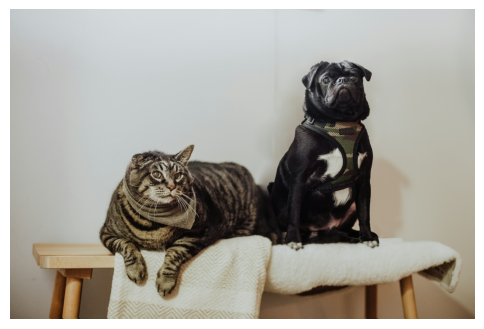

In [ ]:
#Загружаем  изображение
url = 'https://github.com/SadSabrina/explainable_AI_course/blob/main/HW_module10.1_gradient_methods/cat_and_dog.jpg?raw=true'

image_bytes = requests.get(url).content
image = Image.open(BytesIO(image_bytes)) # Как всегда рассмотрим конкретный пример x_0

plt.figure(figsize=(6,8))
plt.axis('off')
plt.imshow(image);

Определим два pipeline:

- для предобработки изображения перед подачей модели (значения для нормализации возьмем, релевантные для набора данных imagenet (так как будем работать с сетью, на нём обученной)).

- для отображения оригинального изображения, поскольку мы будем сравнивать карту активации с оригиналом

In [ ]:
#1
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
   transforms.Resize((224,224)),
])

#2
display = transforms.Compose([transforms.Resize((224,224))])

In [ ]:
# преобразуем изображение
preprocessed_image = preprocess(image).unsqueeze(0)

## **Построение Class Activation Map.**

Познакомимся с процессом построения CAM. Для карты активации нам нужны:

-  Карты активации сверточного слоя $A^k \in R^{u\times u}$, $k=1,2 ... n$
- Веса, отвечающие за прогноз класса $c$ ($w^c)$.

При данных переменных, карта активации записывается как:
$$M_c(x, y) = \sum_k w^c_kA_k $$ — class activation map для класса $c$.

​Как получить карты активации $A_k$ конкретного слоя? В этом нам помогут ***Hooks.***

Понятие *Hook* не является специальным для DL и встречается также в других областях программирования.

**В общем определении можно сказать так:**

**Hooks** —  это функции, которые автоматически выполняются после определенного события.

В контексте pyTorch хуки — это механизм для получения информации о поведении нейронных сетей во время прямого и обратного прохода. Они позволяют прикреплять пользовательские функции (которые и являются хуками) к тензорам (tensors) и модулям (`torch.nn.Module`) нейронной сети, позволяя отслеживать, изменять или записывать различные аспекты графа вычислений.

In [ ]:
class Hook():

    def __init__(self, m):
      self.hook = m.register_forward_hook(self.hook_func) #цепляемся за forward проход слоя m, переданного при инициализации

    def hook_func(self, module, input, output):
      self.features = ((output.cpu()).data).numpy() #получаем output слоя и лепим в numpy массив

    def remove(self):
      self.hook.remove()

В качестве модели возьмем VGG16. Её архитектура требует дополнительного анализа для построения карт, так что модель — отличная для нашего туториала.

In [ ]:
model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
model.eval();

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 236MB/s]


In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
 #model._modules

In [ ]:
vgg_final_layer = model._modules['avgpool']

vgg_act_maps = Hook(vgg_final_layer)

Теперь, чтобы получить карты, достаточно пропустить пример через модель.

In [ ]:
prediction = model(preprocessed_image) #forward pass
pred_prob = F.softmax(prediction, -1).data.squeeze()

In [ ]:
vgg_act_maps.remove()
vgg_act_maps.features.shape

(1, 512, 7, 7)

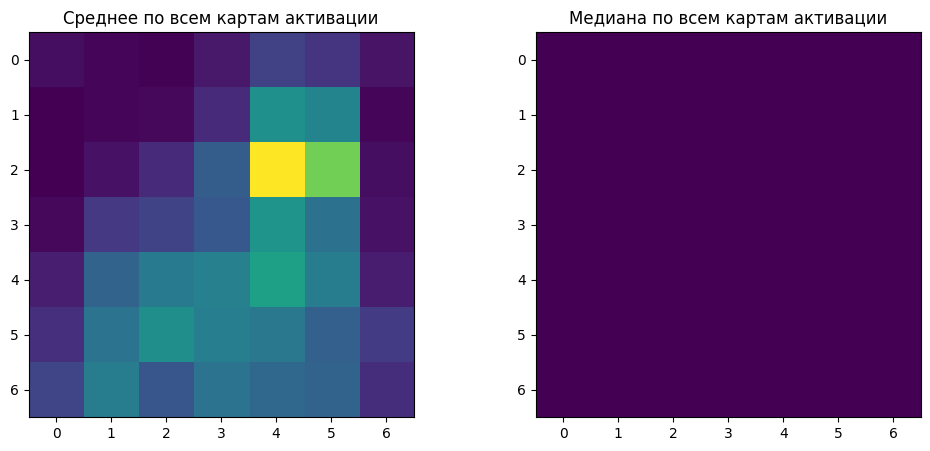

In [ ]:
# Посмотрим на среднее по всем 512 картам

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(vgg_act_maps.features[0].mean(axis=0))
ax[0].set_title('Среднее по всем картам активации')

ax[1].imshow(np.median(vgg_act_maps.features[0], axis=0))
ax[1].set_title('Медиана по всем картам активации');

In [ ]:
idx = topk(pred_prob, 1)[1].int()[0]
print(f'Прогноз модели класс № {idx}')

Прогноз модели класс № 568


In [ ]:
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
urllib.request.urlretrieve(url, "imagenet_classes.txt")

with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [ ]:
for i in topk(pred_prob, 10)[1]:
  print(categories[i])

fur coat
pug
radiator
Egyptian cat
tabby
cowboy boot
miniskirt
Labrador retriever
stole
studio couch


Похоже модель с наибольшей вероятностью видит шубу в нашем изображении. Извлечем параметры самого последнего слоя. Обратите внимание, что их размерность равна (`num_classes`, `num_in_features`) поскольку каждому классу соответствует свой набор весов, который связывает входные карты признаков с этим классом.

In [ ]:
model._modules['classifier'][-1].weight.shape # смотрим размерность воследнего слоя

torch.Size([1000, 4096])

Теперь начнем процесс построения CAM.

In [ ]:
weights_interested = model._modules['classifier'][-1].weight[568, :]  #w^c_k извлечем интересующий нас класс
weights_interested = weights_interested.cpu().data.numpy()

weights_interested.shape

(4096,)

И на этом шаге нам нужно только применить формулу:
$$M_c(x, y) = \sum_k w^c_kA_k $$

Но пока что есть проблема. Карты активации имеют размерность, которую невозможно перемножить на размерность весов.

In [ ]:
vgg_act_maps.features[0].shape, weights_interested.shape

((512, 7, 7), (4096,))

В таки случаях, делаем следующее:
- размерность карт активации меняем, как `количество x вторая и третья размерности` (512, 7*7) — то есть сглаживаем все карты
- размерность весов меняем, как `первая размерность карт x остаток` то есть (512, -1).

In [ ]:
cam = -1*weights_interested.reshape(8, 512) @ vgg_act_maps.features[0].reshape(512, -1)
print(cam.shape)

(8, 49)


После снова берём среднее или медиану по результату.

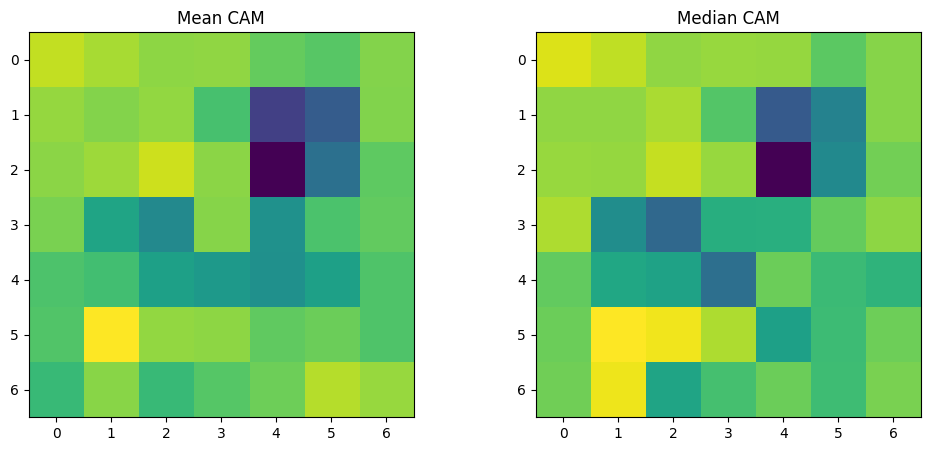

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(cam.mean(axis=0).reshape((7, 7)))
ax[0].set_title('Mean CAM')

ax[1].imshow(np.median(cam, axis=0).reshape((7, 7)))
ax[1].set_title('Median CAM');

In [ ]:
cam = np.median(cam, axis=0).reshape((7, 7))

Для улучшения читаемости, карту можно наложить на изображение. Чтобы это сделать, нужно привести её к соответствующем размеру. А именно от $7\times 7$ к $224\times 224$. Это можно сделать при помощи `torch.nn.Functional.interpolate()`.

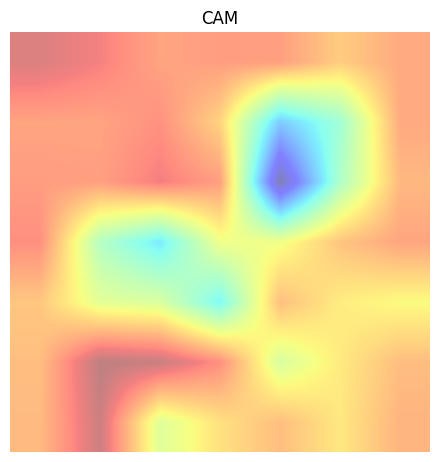

In [ ]:
cam_tensor = torch.from_numpy(cam).float().unsqueeze(0).unsqueeze(0)  # Преобразовываем обратно в тензор
interpol = F.interpolate(cam_tensor, (224, 224), mode="bilinear").squeeze(0).squeeze(0) # Интерполируем карту на изображение

plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(interpol, alpha=0.5, cmap='jet');
plt.title('CAM')
plt.axis('off');

В завершение наведём красоту и отобразим результат.

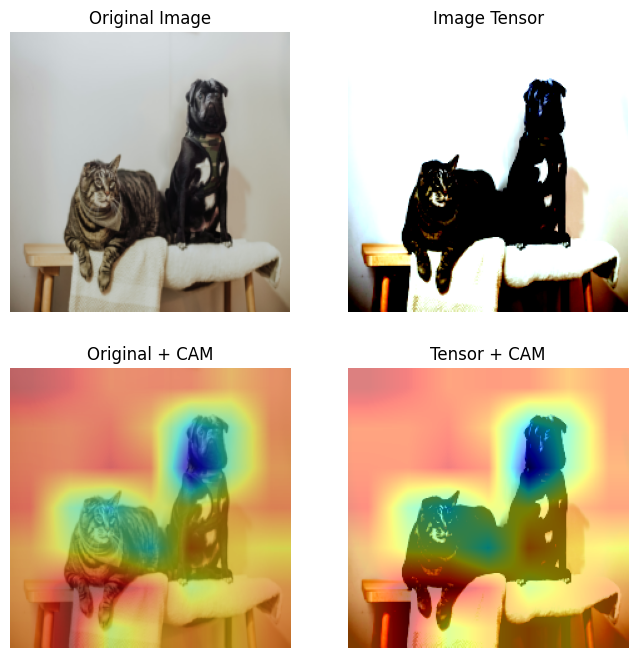

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(display(image))
plt.axis('off')
plt.title('Original Image')

plt.subplot(222)
imshow(preprocessed_image.squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.title('Image Tensor')


plt.subplot(223)
imshow(display(image))
plt.axis('off')
imshow(interpol, alpha=0.5, cmap='jet');
plt.title('Original + CAM')


plt.subplot(224)
imshow(preprocessed_image.squeeze(0).permute(1, 2, 0))
plt.axis('off')
imshow(interpol, alpha=0.5, cmap='jet')
plt.title('Tensor + CAM');

Вот так вот, друзья! Для Vgg на этом изображении собака похожа на шубу. 🧥 Спасибо за внимание!

Буду рада вашим вопросам в комментариях к видео.

Огромное спасибо за ваше внимание! 🤗 Надеюсь,  материал окажется полезным в ваших проектах. Не забывайте поэкспериментировать с другими изображениями!.

Присоединяйтесь к [каналу в телеграм](https://t.me/jdata_blog), чтобы видеть новые туториалы! Также приглашаю пройти мой [курс](https://stepik.org/a/198640) по explainable AI и, конечно, буду рада видеть в профессиональной сети через[LinkedIn](https://www.linkedin.com/in/sabrina-sadiekh-35181a286/).

Больше туториалов (rus + eng) на моём гитхаб:[XAI-open_materials](https://github.com/SadSabrina/XAI-open_materials/tree/main)!

Успешных вам проектов!
Ваш Дата-автор!